In [1]:
import xlb
from xlb.compute_backend import ComputeBackend
from xlb.precision_policy import PrecisionPolicy
from xlb.grid import grid_factory
from xlb.operator.stepper import IncompressibleNavierStokesStepper
from xlb.distribute import distribute
from xlb.operator.boundary_condition import (
    FullwayBounceBackBC,
    HalfwayBounceBackBC,
    RegularizedBC,
    ExtrapolationOutflowBC,
)
from xlb.operator.macroscopic import Macroscopic
from xlb.utils import save_image
import warp as wp
import numpy as np
import jax.numpy as jnp
import time
import jax

In [2]:
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
class vonKarmanVortex:
    def __init__(self, omega, inlet_velocity_mean, cylinder_diameter, grid_shape, velocity_set, backend, precision_policy):
        # initialize backend
        xlb.init(
            velocity_set=velocity_set,
            default_backend=backend,
            default_precision_policy=precision_policy,
        )

        self.grid_shape = grid_shape
        self.velocity_set = velocity_set
        self.backend = backend
        self.precision_policy = precision_policy
        self.omega = omega
        self.boundary_conditions = []
        self.u_max = 1.5 * inlet_velocity_mean
        self.cylinder_diameter = cylinder_diameter

        # Create grid using factory
        self.grid = grid_factory(grid_shape, compute_backend=backend)

        # Setup the simulation BC and stepper
        self._setup()

    def _setup(self):
        self.setup_boundary_conditions()
        self.setup_stepper()

    def define_boundary_indices(self):
        box = self.grid.bounding_box_indices()
        box_no_edge = self.grid.bounding_box_indices(remove_edges=True)
        inlet = box_no_edge["left"]
        outlet = box_no_edge["right"]
        walls = [box["bottom"][i] + box["top"][i] for i in range(self.velocity_set.d)]
        walls = np.unique(np.array(walls), axis=-1).tolist()

        cyliner_radius = self.cylinder_diameter // 2
        x = np.arange(self.grid_shape[0])
        y = np.arange(self.grid_shape[1])
        X, Y = np.meshgrid(x, y, indexing="ij")
        indices = np.where((X - 2.0 * self.cylinder_diameter) ** 2 + (Y - 2.0 * self.cylinder_diameter) ** 2 < cyliner_radius**2)
        cyliner = [tuple(indices[i]) for i in range(self.velocity_set.d)]

        return inlet, outlet, walls, cyliner

    def setup_boundary_conditions(self):
        inlet, outlet, walls, cyliner = self.define_boundary_indices()
        bc_left = RegularizedBC("velocity", profile=self.bc_profile(), indices=inlet)
        bc_walls = HalfwayBounceBackBC(indices=walls)
        bc_outlet = ExtrapolationOutflowBC(indices=outlet)
        bc_cyliner = HalfwayBounceBackBC(indices=cyliner)
        self.boundary_conditions = [bc_walls, bc_left, bc_outlet, bc_cyliner]

    def setup_stepper(self):
        stepper = IncompressibleNavierStokesStepper(
            omega=self.omega,
            grid=self.grid,
            boundary_conditions=self.boundary_conditions,
            collision_type="BGK",
        )
        # Distribute the stepper
        self.stepper = distribute(
            stepper,
            self.grid,
            self.velocity_set,
        )
        self.f_0, self.f_1, self.bc_mask, self.missing_mask = self.stepper.prepare_fields()

    def bc_profile(self):
        u_max = self.u_max  # u_max = 0.04
        # Get the grid dimensions for the y direction
        H_y = float(self.grid_shape[1] - 1)  # Height in y direction

        @wp.func
        def bc_profile_warp(index: wp.vec3i):
            # Poiseuille flow profile: parabolic velocity distribution
            y = self.precision_policy.store_precision.wp_dtype(index[1])

            # Calculate normalized distance from center
            y_center = y - (H_y / 2.0)
            r_squared = (2.0 * y_center / H_y) ** 2.0

            # Parabolic profile: u = u_max * (1 - r²)
            return wp.vec(u_max * wp.max(0.0, 1.0 - r_squared), length=1)

        def bc_profile_jax():
            y = jnp.arange(self.grid_shape[1])

            # Calculate normalized distance from center
            y_center = y - (H_y / 2.0)
            r_squared = (2.0 * y_center / H_y) ** 2.0

            # Parabolic profile for x velocity, zero for y and z
            u_x = u_max * jnp.maximum(0.0, 1.0 - r_squared)
            u_y = jnp.zeros_like(u_x)

            return jnp.stack([u_x, u_y])

        if self.backend == ComputeBackend.JAX:
            return bc_profile_jax
        elif self.backend == ComputeBackend.WARP:
            return bc_profile_warp

    def run(self, num_steps, post_process_interval=100):
        start_time = time.time()
        for i in range(num_steps):
            self.f_0, self.f_1 = self.stepper(self.f_0, self.f_1, self.bc_mask, self.missing_mask, i)
            self.f_0, self.f_1 = self.f_1, self.f_0

            if i % post_process_interval == 0 or i == num_steps - 1:
                self.post_process(i)
                end_time = time.time()
                print(f"Completing {i} iterations. Time elapsed for 1000 LBM steps in {end_time - start_time:.6f} seconds.")
                start_time = time.time()

    def post_process(self, i):
        # Write the results. We'll use JAX backend for the post-processing
        if not isinstance(self.f_0, jnp.ndarray):
            f_0 = wp.to_jax(self.f_0)
        else:
            f_0 = self.f_0

        macro = Macroscopic(
            compute_backend=ComputeBackend.JAX,
            precision_policy=self.precision_policy,
            velocity_set=xlb.velocity_set.D2Q9(precision_policy=self.precision_policy, backend=ComputeBackend.JAX),
        )
        rho, u = macro(f_0)
        u = u[:, :-1, :]
        rho = rho[:, :-1, :]
        u_magnitude = (u[0] ** 2 + u[1] ** 2) ** 0.5

        fields = {"u_magnitude": u_magnitude, "u_x": u[0], "u_y": u[1], "rho": rho[0]}

        # save_fields_vtk(fields, timestep=i)
        save_image(fields["u_magnitude"], timestep=i)


In [4]:
cylinder_diameter = 20
scaling_factor = 80/cylinder_diameter
nx = int(9 * cylinder_diameter)
ny = int(4.1 * cylinder_diameter)
grid_shape = (nx, ny)

backend = ComputeBackend.JAX
precision_policy = PrecisionPolicy.FP32FP32
velocity_set = xlb.velocity_set.D2Q9(precision_policy=precision_policy, backend=backend)

Re = 150.0
inlet_velocity_mean = 0.003 * scaling_factor
visc = inlet_velocity_mean * cylinder_diameter / Re
omega = 1.0 / (3.0 * visc + 0.5)

simulation1 = vonKarmanVortex(omega, inlet_velocity_mean, cylinder_diameter, grid_shape, velocity_set, backend, precision_policy)


Multi-GPU support is available: 2 GPUs detected.
No GPU support is available; CPU fallback will be used.
registered bc RegularizedBC_8656322137731 with id 1
registered bc HalfwayBounceBackBC_8656322137713 with id 2
registered bc ExtrapolationOutflowBC_8656322152512 with id 3
registered bc HalfwayBounceBackBC_8656322152542 with id 4


In [5]:
cylinder_diameter = 20
scaling_factor = 80/cylinder_diameter
nx = int(9 * cylinder_diameter)
ny = int(4.1 * cylinder_diameter)
grid_shape = (nx, ny)

backend = ComputeBackend.JAX
precision_policy = PrecisionPolicy.FP32FP32
velocity_set = xlb.velocity_set.D2Q9(precision_policy=precision_policy, backend=backend)

Re = 130.0
inlet_velocity_mean = 0.003 * scaling_factor
visc = inlet_velocity_mean * cylinder_diameter / Re
omega = 1.0 / (3.0 * visc + 0.5)

simulation2 = vonKarmanVortex(omega, inlet_velocity_mean, cylinder_diameter, grid_shape, velocity_set, backend, precision_policy)


Multi-GPU support is available: 2 GPUs detected.
No GPU support is available; CPU fallback will be used.
registered bc RegularizedBC_8656318862946 with id 5
registered bc HalfwayBounceBackBC_8656481639671 with id 6
registered bc ExtrapolationOutflowBC_8656318875967 with id 7
registered bc HalfwayBounceBackBC_8656318876201 with id 8


In [11]:
(simulation2.f_1 - simulation1.f_1).sum()

Array(0., dtype=float32)

In [3]:
backend = ComputeBackend.JAX
precision_policy = PrecisionPolicy.FP64FP64
velocity_set = xlb.velocity_set.D2Q9(precision_policy=precision_policy, backend=backend)
cylinder_diameter = 20
scaling_factor = 80/cylinder_diameter
nx = int(9 * cylinder_diameter)
ny = int(4.1 * cylinder_diameter)
grid_shape = (nx, ny)
grid = grid_factory(grid_shape, compute_backend=backend)

In [4]:
xlb.init(
    velocity_set=velocity_set,
    default_backend=backend,
    default_precision_policy=precision_policy,
)

Multi-GPU support is available: 2 GPUs detected.
No GPU support is available; CPU fallback will be used.


In [5]:
def bc_profile(u_max):
    u_max = u_max  # u_max = 0.04
    # Get the grid dimensions for the y direction
    H_y = float(grid_shape[1] - 1)  # Height in y direction

    def bc_profile_jax():
        y = jnp.arange(grid_shape[1])

        # Calculate normalized distance from center
        y_center = y - (H_y / 2.0)
        r_squared = (2.0 * y_center / H_y) ** 2.0

        # Parabolic profile for x velocity, zero for y and z
        u_x = u_max * jnp.maximum(0.0, 1.0 - r_squared)
        u_y = jnp.zeros_like(u_x)

        return jnp.stack([u_x, u_y])

    return bc_profile_jax


In [6]:
def setup_boundaries(u_max):
    box = grid.bounding_box_indices()
    box_no_edge = grid.bounding_box_indices(remove_edges=True)
    inlet = box_no_edge["left"]
    outlet = box_no_edge["right"]
    walls = [box["bottom"][i] + box["top"][i] for i in range(velocity_set.d)]
    walls = np.unique(np.array(walls), axis=-1).tolist()

    cyliner_radius = cylinder_diameter // 2
    x = np.arange(grid_shape[0])
    y = np.arange(grid_shape[1])
    X, Y = np.meshgrid(x, y, indexing="ij")
    indices = np.where((X - 2.0 * cylinder_diameter) ** 2 + (Y - 2.0 * cylinder_diameter) ** 2 < cyliner_radius**2)
    cyliner = [tuple(indices[i]) for i in range(velocity_set.d)]

    bc_left = RegularizedBC("velocity", profile=bc_profile(u_max), indices=inlet)
    bc_walls = HalfwayBounceBackBC(indices=walls)
    bc_outlet = ExtrapolationOutflowBC(indices=outlet)
    bc_cyliner = HalfwayBounceBackBC(indices=cyliner)
    return [bc_walls, bc_left, bc_outlet, bc_cyliner]

In [7]:
key = jax.random.PRNGKey(0)
NUM_SAMPLES = 5
reynolds = jax.random.uniform(key, (NUM_SAMPLES,), jnp.float32, minval=100., maxval=200.)
trajs = []
omegas = []
inlet_visc_means = []
dimaters = []
f0s = []
f1s = []
bc_masks = []
missings_masks = []
for Re in reynolds:
    inlet_velocity_mean = 0.003 * scaling_factor
    visc = inlet_velocity_mean * cylinder_diameter / Re
    omega = 1.0 / (3.0 * visc + 0.5)
    u_max = 1.5 * inlet_velocity_mean
    bc_list = setup_boundaries(u_max)
    stepper = IncompressibleNavierStokesStepper(
        omega=omega,
        grid=grid,
        boundary_conditions=bc_list,
        collision_type="BGK"
    )
    f0, f1, bc_mask, missing_mask = stepper.prepare_fields()
    bc_masks.append(bc_mask)
    missings_masks.append(missing_mask)
    f1s.append(f1)
    f0s.append(f0)
    omegas.append(omega)
    dimaters.append(cylinder_diameter)
    inlet_visc_means.append(inlet_velocity_mean)

registered bc RegularizedBC_8615620063860 with id 1
registered bc HalfwayBounceBackBC_8615620063893 with id 2
registered bc ExtrapolationOutflowBC_8615620064190 with id 3
registered bc HalfwayBounceBackBC_8615620081118 with id 4
registered bc RegularizedBC_8615617431883 with id 5
registered bc HalfwayBounceBackBC_8615617432279 with id 6
registered bc ExtrapolationOutflowBC_8615617441120 with id 7
registered bc HalfwayBounceBackBC_8615617441324 with id 8
registered bc RegularizedBC_8615617446384 with id 9
registered bc HalfwayBounceBackBC_8615617446000 with id 10
registered bc ExtrapolationOutflowBC_8615617452687 with id 11
registered bc HalfwayBounceBackBC_8615617455579 with id 12
registered bc RegularizedBC_8615617458696 with id 13
registered bc HalfwayBounceBackBC_8615617468474 with id 14
registered bc ExtrapolationOutflowBC_8615617472990 with id 15
registered bc HalfwayBounceBackBC_8615617473113 with id 16
registered bc RegularizedBC_8615617476251 with id 17
registered bc HalfwayBou

In [8]:
f0s = jnp.stack(f0s)
f1s = jnp.stack(f1s)
omegas = jnp.array(omegas)
dimaters = jnp.array(dimaters)
inlet_visc_means = jnp.array(inlet_visc_means)
bc_masks = jnp.stack(bc_masks)
missings_masks = jnp.stack(missings_masks)

In [10]:
stepper = distribute(
    stepper,
    grid,
    velocity_set
)

In [16]:
trajs = [f0s]
for t in range(1, 50000):
    _, f0s = jax.vmap(stepper, in_axes=(0, 0, 0, 0, None))(f0s, f1s, bc_masks, missings_masks, 0)
    # print(1)
    if t % 100 == 0:
        # print(t)
        trajs.append(f0s)

In [12]:
trajs = jnp.stack(trajs, axis=1)

In [13]:
macro = Macroscopic(
    compute_backend=ComputeBackend.JAX,
    precision_policy=precision_policy,
    velocity_set=xlb.velocity_set.D2Q9(precision_policy=precision_policy, backend=ComputeBackend.JAX),
)

In [14]:
def post_process(field):
    rho, u = macro(field)
    u = u[:, :-1, :]
    rho = rho[:, :-1, :]
    # u_magnitude = (u[0] ** 2 + u[1] ** 2) ** 0.5
    return u

In [15]:
trajs_velocity = jax.vmap(jax.vmap(post_process))(trajs)

In [16]:
trajs_velocity.shape

(5, 500, 2, 179, 82)

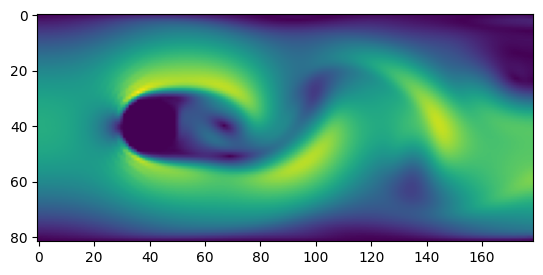

In [21]:
i=4
t=-1
plt.imshow(jnp.linalg.norm(trajs_velocity[i][t], axis=0).T)

In [18]:
trajs

(5, 500, 9, 180, 82)

In [ ]:
(trajs[-1] - trajs[0]).max()

Array(0.01991266, dtype=float32)

In [ ]:
import xlb
from xlb.compute_backend import ComputeBackend
from xlb.precision_policy import PrecisionPolicy
from xlb.grid import grid_factory
from xlb.operator.stepper import IncompressibleNavierStokesStepper
from xlb.distribute import distribute
from xlb.operator.boundary_condition import (
    FullwayBounceBackBC,
    HalfwayBounceBackBC,
    RegularizedBC,
    ExtrapolationOutflowBC,
)
from xlb.operator.macroscopic import Macroscopic
from xlb.utils import save_image
import warp as wp
import numpy as np
import jax.numpy as jnp
import time


class vonKarmanVortex:
    def __init__(self, omega, inlet_velocity_mean, cylinder_diameter, grid_shape, velocity_set, backend, precision_policy):
        # initialize backend
        xlb.init(
            velocity_set=velocity_set,
            default_backend=backend,
            default_precision_policy=precision_policy,
        )

        self.grid_shape = grid_shape
        self.velocity_set = velocity_set
        self.backend = backend
        self.precision_policy = precision_policy
        self.omega = omega
        self.boundary_conditions = []
        self.u_max = 1.5 * inlet_velocity_mean
        self.cylinder_diameter = cylinder_diameter

        # Create grid using factory
        self.grid = grid_factory(grid_shape, compute_backend=backend)

        # Setup the simulation BC and stepper
        self._setup()

    def _setup(self):
        self.setup_boundary_conditions()
        self.setup_stepper()

    def define_boundary_indices(self):
        box = self.grid.bounding_box_indices()
        box_no_edge = self.grid.bounding_box_indices(remove_edges=True)
        inlet = box_no_edge["left"]
        outlet = box_no_edge["right"]
        walls = [box["bottom"][i] + box["top"][i] for i in range(self.velocity_set.d)]
        walls = np.unique(np.array(walls), axis=-1).tolist()

        cyliner_radius = self.cylinder_diameter // 2
        x = np.arange(self.grid_shape[0])
        y = np.arange(self.grid_shape[1])
        X, Y = np.meshgrid(x, y, indexing="ij")
        indices = np.where((X - 2.0 * self.cylinder_diameter) ** 2 + (Y - 2.0 * self.cylinder_diameter) ** 2 < cyliner_radius**2)
        cyliner = [tuple(indices[i]) for i in range(self.velocity_set.d)]

        return inlet, outlet, walls, cyliner

    def setup_boundary_conditions(self):
        inlet, outlet, walls, cyliner = self.define_boundary_indices()
        bc_left = RegularizedBC("velocity", profile=self.bc_profile(), indices=inlet)
        bc_walls = HalfwayBounceBackBC(indices=walls)
        bc_outlet = ExtrapolationOutflowBC(indices=outlet)
        bc_cyliner = HalfwayBounceBackBC(indices=cyliner)
        self.boundary_conditions = [bc_walls, bc_left, bc_outlet, bc_cyliner]

    def setup_stepper(self):
        stepper = IncompressibleNavierStokesStepper(
            omega=self.omega,
            grid=self.grid,
            boundary_conditions=self.boundary_conditions,
            collision_type="BGK",
        )
        # Distribute the stepper
        self.stepper = distribute(
            stepper,
            self.grid,
            self.velocity_set,
        )
        self.f_0, self.f_1, self.bc_mask, self.missing_mask = self.stepper.prepare_fields()

    def bc_profile(self):
        u_max = self.u_max  # u_max = 0.04
        # Get the grid dimensions for the y direction
        H_y = float(self.grid_shape[1] - 1)  # Height in y direction

        @wp.func
        def bc_profile_warp(index: wp.vec3i):
            # Poiseuille flow profile: parabolic velocity distribution
            y = self.precision_policy.store_precision.wp_dtype(index[1])

            # Calculate normalized distance from center
            y_center = y - (H_y / 2.0)
            r_squared = (2.0 * y_center / H_y) ** 2.0

            # Parabolic profile: u = u_max * (1 - r²)
            return wp.vec(u_max * wp.max(0.0, 1.0 - r_squared), length=1)

        def bc_profile_jax():
            y = jnp.arange(self.grid_shape[1])

            # Calculate normalized distance from center
            y_center = y - (H_y / 2.0)
            r_squared = (2.0 * y_center / H_y) ** 2.0

            # Parabolic profile for x velocity, zero for y and z
            u_x = u_max * jnp.maximum(0.0, 1.0 - r_squared)
            u_y = jnp.zeros_like(u_x)

            return jnp.stack([u_x, u_y])

        if self.backend == ComputeBackend.JAX:
            return bc_profile_jax
        elif self.backend == ComputeBackend.WARP:
            return bc_profile_warp

    def run(self, num_steps, post_process_interval=100):
        start_time = time.time()
        for i in range(num_steps):
            self.f_0, self.f_1 = self.stepper(self.f_0, self.f_1, self.bc_mask, self.missing_mask, i)
            self.f_0, self.f_1 = self.f_1, self.f_0

            if i % post_process_interval == 0 or i == num_steps - 1:
                self.post_process(i)
                end_time = time.time()
                print(f"Completing {i} iterations. Time elapsed for 1000 LBM steps in {end_time - start_time:.6f} seconds.")
                start_time = time.time()

    def post_process(self, i):
        # Write the results. We'll use JAX backend for the post-processing
        if not isinstance(self.f_0, jnp.ndarray):
            f_0 = wp.to_jax(self.f_0)
        else:
            f_0 = self.f_0

        macro = Macroscopic(
            compute_backend=ComputeBackend.JAX,
            precision_policy=self.precision_policy,
            velocity_set=xlb.velocity_set.D2Q9(precision_policy=self.precision_policy, backend=ComputeBackend.JAX),
        )
        rho, u = macro(f_0)
        u = u[:, :-1, :]
        rho = rho[:, :-1, :]
        u_magnitude = (u[0] ** 2 + u[1] ** 2) ** 0.5

        fields = {"u_magnitude": u_magnitude, "u_x": u[0], "u_y": u[1], "rho": rho[0]}

        # save_fields_vtk(fields, timestep=i)
        save_image(fields["u_magnitude"], timestep=i)


if __name__ == "__main__":
    # Running the simulation
    cylinder_diameter = 20
    scaling_factor = 80/cylinder_diameter
    nx = int(9 * cylinder_diameter)
    ny = int(4.1 * cylinder_diameter)
    grid_shape = (nx, ny)

    backend = ComputeBackend.JAX
    precision_policy = PrecisionPolicy.FP32FP32
    velocity_set = xlb.velocity_set.D2Q9(precision_policy=precision_policy, backend=backend)

    Re = 200.0
    inlet_velocity_mean = 0.003 * scaling_factor
    visc = inlet_velocity_mean * cylinder_diameter / Re
    omega = 1.0 / (3.0 * visc + 0.5)

    simulation = vonKarmanVortex(omega, inlet_velocity_mean, cylinder_diameter, grid_shape, velocity_set, backend, precision_policy)
    simulation.run(num_steps=100000, post_process_interval=500)

    

In [6]:
key = jax.random.PRNGKey(0)
NUM_SAMPLES = 10
reynolds = jax.random.uniform(key, (NUM_SAMPLES,), jnp.float32, minval=100., maxval=200.)
trajs = []
omegas = []
inlet_visc_means = []
dimaters = []
for Re in reynolds:
    inlet_velocity_mean = 0.003 * scaling_factor
    visc = inlet_velocity_mean * cylinder_diameter / Re
    omega = 1.0 / (3.0 * visc + 0.5)
    simulation = vonKarmanVortex(omega, inlet_velocity_mean, cylinder_diameter, grid_shape, velocity_set, backend, precision_policy)
    field_0 = simulation.f_0
    field_1 = simulation.f_1
    traj = [field_0]
    for i in range(1, 50001):
        _, field_0 = simulation.stepper(field_0, field_1, simulation.bc_mask, simulation.missing_mask, i)
        if i % 100 == 0:
            traj.append(field_0)
    traj = np.stack(traj)
    trajs.append(traj)
    omegas.append(omega)
    inlet_visc_means.append(inlet_velocity_mean)
    dimaters.append(cylinder_diameter)
    

No GPU support is available; CPU fallback will be used.
registered bc RegularizedBC_8519176880189 with id 1
registered bc HalfwayBounceBackBC_8519176880162 with id 2
registered bc ExtrapolationOutflowBC_8519176880975 with id 3
registered bc HalfwayBounceBackBC_8519176893903 with id 4
No GPU support is available; CPU fallback will be used.
registered bc RegularizedBC_8519174318903 with id 5
registered bc HalfwayBounceBackBC_8519174318645 with id 6
registered bc ExtrapolationOutflowBC_8519173609055 with id 7
registered bc HalfwayBounceBackBC_8519173615022 with id 8
No GPU support is available; CPU fallback will be used.
registered bc RegularizedBC_8519173666886 with id 9
registered bc HalfwayBounceBackBC_8519173666901 with id 10
registered bc ExtrapolationOutflowBC_8519172948260 with id 11
registered bc HalfwayBounceBackBC_8519172948857 with id 12


In [7]:
macro = Macroscopic(
    compute_backend=ComputeBackend.JAX,
    precision_policy=precision_policy,
    velocity_set=xlb.velocity_set.D2Q9(precision_policy=precision_policy, backend=ComputeBackend.JAX),
)

In [8]:
def evolve(field_1, dt, dx, f1_solver, bc_mask, missing_mask, *args):
    _, field_1 = simulation.stepper(field_1, f1_solver, bc_mask, missing_mask, 0)
    return field_1

In [9]:
field_2 = simulation.f_0

In [55]:
for _ in range(10000):
    field_2 = evolve(field_2, 1, None, simulation.f_1, simulation.bc_mask, simulation.missing_mask)

In [56]:

rho, u = macro(field_2)
u = u[:, :-1, :]
rho = rho[:, :-1, :]
u_magnitude = (u[0] ** 2 + u[1] ** 2) ** 0.5

In [36]:
import matplotlib.pyplot as plt

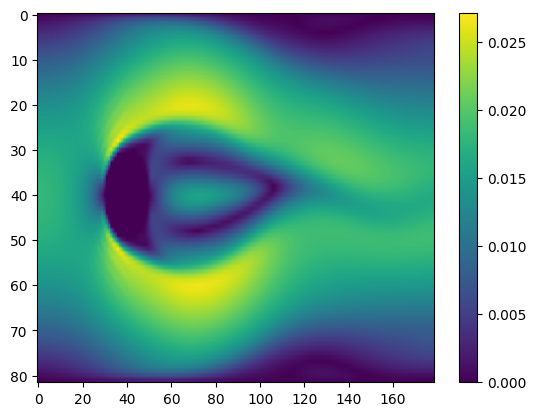

In [57]:
plt.imshow(u_magnitude.T, aspect="auto")
plt.colorbar()

In [73]:
len(simulation.grid.bounding_box_indices(remove_edges=True)['bottom'][0])

178